In [1]:
%load_ext autoreload
%autoreload 1
%aimport gp_utils

In [ ]:
from gp_utils import kernel1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
np.random.seed(7)

## Visualizing Random Samples from Multivariate Gaussian as Lines

In [89]:
def samplePlot(mu, covMat, cholMat, nSamples=10, d1=0, d2=2):
    # sample points
    samples = np.random.normal(size=(cholMat.shape[0], nSamples))
    f = mu.reshape(-1,1) + np.dot(cholMat, samples)

    # plot
    X1, X2 = np.meshgrid(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1))
    fig = plt.figure(1, figsize=(9, 4))

    # 2D joint Gaussian distribution with sample points
    ax1 = plt.subplot(1,2,1)
    sigx1, sigx2 = np.sqrt(covMat[d1,d1]), np.sqrt(covMat[d2,d2])
    sigx1x2 = covMat[d1, d2]/(sigx1*sigx2)
    Z = mlab.bivariate_normal(X1, X2, sigmax=sigx1, sigmay=sigx2, mux=mu[d1], muy=mu[d2], sigmaxy=sigx1x2)
    plt.contour(X1, X2, Z, zorder=10, colors='r')
    plt.plot(f[d1,:], f[d2,:], ls='None', marker='o', markersize=3, mec='0.5', mfc='0.8', mew=0.5)
    plt.axis('scaled')
    plt.xlabel('X{:d}'.format(d1))
    plt.ylabel('X{:d}'.format(d2))
    
    # plot samples as curves
    ax2 = plt.subplot(1,2,2)
    plt.plot(f)
    plt.xlabel('$X_i$')
    plt.ylabel('$f(X_i)$')
    plt.show()
    return f

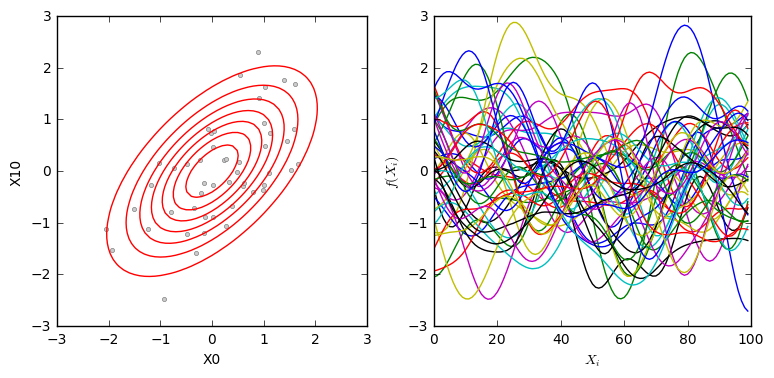

In [87]:
# construct test array specifying number of query points (dimension of joint Gaussian will be of nTest)
nTest = 100
xTest = np.linspace(0,10,nTest).reshape(-1,1)

# calculate covariance matrix of joint Gaussian
K = sqrExpKernel(xTest, xTest)
# assume zero mean for each dim of joint Gaussian
mu = np.zeros(nTest)

# calculate Cholesky decomposition of covariance matrix
sigYSqrd = 1e-6
L = np.linalg.cholesky(K + sigYSqrd*np.eye(nTest))

# sample from joint distribution and plot
fRandom = samplePlot(mu, K, L, nSamples=50, d1=0, d2=10)

## Noiseless GP Regression

To do noiseless GP regression, it is necessary to calculate
$$\mu_* = \overline{f_*} = \mathbf{k}_*^T\mathbf{K}^{-1}\mathbf{y}$$
at each query point, where $\mathbf{y}$ is simply the $f$ values of the training data. Since $\mathbf{K}$ is not properly constrained, calculating the inverse of this matrix becomes unstable.  A better approach is the following:
* Apply Cholesky decomposition to $\mathbf{K}$ to obtain $\mathbf{L}$
$$ \mathbf{K} = \mathbf{L}\mathbf{L}^{T} $$
* Define $\alpha$ as follow, and substitute for $\mathbf{K}$:
$$\alpha = \mathbf{K}^{-1}\mathbf{y} = \mathbf{L}^{-T}\mathbf{L}^{-1}\mathbf{y}$$
* Let $\mathbf{m} = \mathbf{L}^{-1}\mathbf{y}$, so that
$$\mathbf{L m} = \mathbf{y}$$
is a linear system of equations from which $m$ can be solved.
* This gives $\mathbf{\alpha} = \mathbf{L}^{-T}\mathbf{m}$, so that
$$ \mathbf{L}^T \alpha = \mathbf{m} $$
is another linear system of equations from which $\mathbf{\alpha}$ can be solved.

A similar approach can be followed to calculate $\Sigma_{*}$ from the equation
$$ \Sigma_{*} = \mathbf{K}_{**} - \mathbf{K}_*^T\mathbf{K}^{-1}\mathbf{K}_*$$


### Training data

First we need to come up with some training data.  This can be done by constructing an arbitrary nonlinear function to serve as the underlying ground truth, and then rondomly sample points from this function.

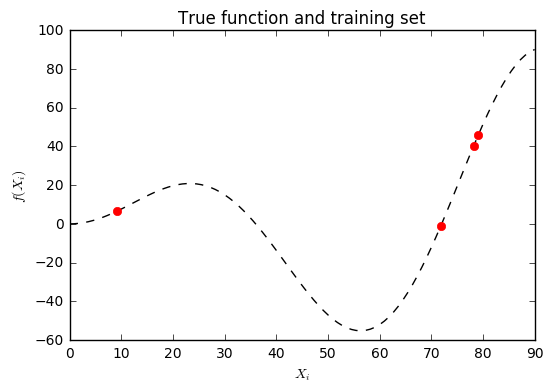

In [53]:
# create data to serve as the true underlying function
xTrue = np.linspace(0,90,100)
# define an arbitrary function to be the ground truth
def f(x):
    return  np.sin(5*x*np.pi/180.0)*x
yTrue = f(xTrue)

# randomly sample points from the true function for a training set
nTrain = 4
xTrain = np.sort(np.random.choice(xTrue, nTrain, replace=False))
yTrain = yTrue[xTrue.searchsorted(xTrain)]

# test set
nTest = 1000
xTest = np.linspace(0,100,nTest)

# plot function and training set
fig1 = plt.figure(1)
plt.plot(xTrue, yTrue, ls='--', color='k')
plt.plot(xTrain, yTrain, ls='None', color='r', marker='o', mec='r', mfc='r')
plt.title("True function and training set")
plt.xlabel('$X_i$')
plt.ylabel('$f(X_i)$')
plt.show()

Define a kernel for calculating the covariance matrix

In [54]:
# kernel2
def sqrExpKernel2(a, b, lSqrd, sfSqrd):
    na = len(a)
    nb = len(b)
    K = np.zeros((na,nb))
    for i in np.arange(na):
        for j in np.arange(nb):
            K[i, j] = sfSqrd*np.exp(-0.5*(a[i] - b[j])**2.0/lSqrd)
    return K

Apply Gaussian Processes for regression to estimate the true function (dashed black line), by only using the training data (red points).  The test points (i.e. the $x$ values where we will query for $\mu_*$ and $\sigma_*^2$) will be the vector "xTest".

In [59]:
# construct matrices K, K_*, K_** using kernel2
lSqrd = 100.0
sfSqrd = 500.0
K = sqrExpKernel2(xTrain, xTrain, lSqrd, sfSqrd)
Ks = sqrExpKernel2(xTrain, xTest, lSqrd, sfSqrd)
Kss = sqrExpKernel2(xTest, xTest, lSqrd, sfSqrd)

# calculate Cholesky decomposition of K
sigYSqrd = 1e-6
Ltrain = np.linalg.cholesky(K + sigYSqrd*np.eye(nTrain))

# calculate the predicted mean
# solve for m1 from Lm1 = y
m1 = np.linalg.solve(Ltrain, yTrain)
# solve for alpha1 from L^T*alpha1 = m1 (mu)
alpha1 = np.linalg.solve(Ltrain.T, m1)
# Calculate mu_* of the conditional probability using the theorem
muS = np.dot(Ks.T, alpha1)

# calculate the predicted variance
# solve for m2 from Lm2 = K_*
m2 = np.linalg.solve(Ltrain, Ks)
# Calculate sigma_* of the conditional probability using the theorem (note that if a = AB, then A^T B^T = a^T)
sigmaS = sqrExpKernel2(xTest, xTest, lSqrd, sfSqrd) - np.dot(m2.T, m2)
var = sigmaS.diagonal()
std = np.sqrt(var)

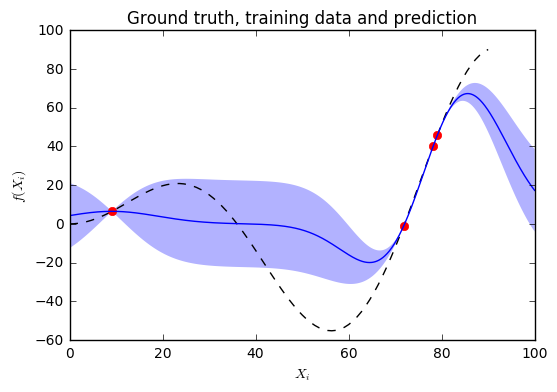

In [60]:
# plot graph
fig1 = plt.figure(1)
plt.plot(xTrue, yTrue, ls='--', color='k')
plt.plot(xTrain, yTrain, ls='None', color='r', marker='o', mec='r', mfc='r')
plt.fill(np.concatenate([xTest.reshape(1,-1).T, xTest.reshape(1,-1).T[::-1]]),
         np.concatenate([muS - std, (muS + std)[::-1]]),
         alpha=.3, fc='b', ec='None')
plt.plot(xTest, muS, ls='-', color='b')
plt.title("Ground truth, training data and prediction")
plt.xlabel('$X_i$')
plt.ylabel('$f(X_i)$')
#plt.savefig("gp_2.pdf", format='pdf')
plt.show()


For illustration purposes, we can now sample from the posterior joint distribution (described by the vector $\mu_*$ and covariance matrix $\Sigma_*$ calculated above).  Samples from this posterior distribution will yield possible regression lines that adhere to constraints imposed by the training data

In [290]:
# hack function to find nearest positive semi-definite matrix
def nearPSD(A, epsilon=0):
    n = A.shape[0]
    eigval, eigvec = np.linalg.eig(A)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec,vec)*val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T*vec*np.diag(np.array(np.sqrt(val)).reshape((n)))
    out = B*B.T
    return out

In [ ]:
# sample from posterior joint Gaussian distribution
# calculate Cholesky decomposition of the covariance matrix (for the test data)
sigYSqrd = 1e-6
Ltest = np.linalg.cholesky(sigmaS + sigYSqrd*np.eye(nTest))

# sample from joint Gaussian to obtain prior
nSamplesPost = 10
samplesPost = np.random.normal(size=(nTest, nSamplesPost))
fPost = muS.reshape(-1,1) + np.dot(Ltest, samplesPost)


# plot 2D gaussian using 1st and last dim
x1 = x2 = np.arange(-3, 3, 0.1)
X1, X2 = np.meshgrid(x1, x2)
d1, d2 = int(0), int(np.round(nTest/10.0))

# plot joint prob distribution for 2 slices
fig1 = plt.figure(1, figsize=(5, 8))
ax1 = plt.subplot(2,1,1)
sigx1 = np.sqrt(sigmaS[d1, d1])
sigx2 = np.sqrt(sigmaS[d2, d2])
sigx1x2 = sigmaS[d1, d2]/(sigx1*sigx2)
Z = mlab.bivariate_normal(X1, X2, sigmax=sigx1, sigmay=sigx2, mux=muS[d1], muy=muS[d2], sigmaxy=sigx1x2)
plt.contour(X1, X2, Z, zorder=10, colors='r' )
plt.plot(fPost[d1,:], fPost[d2,:], ls='None', marker='o', markersize=3, mec='0.5', mfc='0.8', mew=0.5)
plt.axis('scaled')
plt.tight_layout()
plt.xlabel('X1')
plt.ylabel('X{:d}'.format(d2))

ax2 = plt.subplot(2,1,2)
plt.plot(fPost)
plt.xlabel('$X_i$')
plt.ylabel('$f(X_i)$')
#plt.savefig('gp_1p2.pdf', format='pdf')
plt.show()

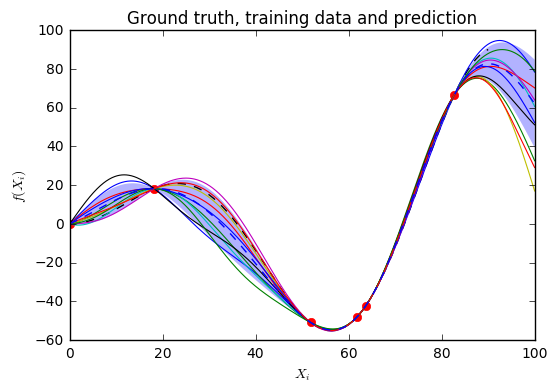

In [52]:
# plot graph
fig1 = plt.figure(1)
plt.plot(xTrue, yTrue, ls='--', color='k')
plt.plot(xTrain, yTrain, ls='None', color='r', marker='o', mec='r', mfc='r')
plt.plot(xTest, fPost, ls='-', lw=0.8)
plt.fill(np.concatenate([xTest.reshape(1,-1).T, xTest.reshape(1,-1).T[::-1]]),
         np.concatenate([muS - std, (muS + std)[::-1]]),
         alpha=.3, fc='b', ec='None')
plt.plot(xTest, muS, ls='--', color='b')
plt.title("Ground truth, training data and prediction")
plt.xlabel('$X_i$')
plt.ylabel('$f(X_i)$')
plt.savefig('gp_3.pdf', format='pdf')
plt.show()